In [46]:
import random
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
from game import Game
from direction import Direction

In [24]:
def play_random_game():
    # Initialize the random game
    random_game = Game()

    # Initialize the board
    init_board = np.array([[0, 0, 0, 0], [0, 0, 0, 0], [0, 0, 0, 0], [0, 0, 0, 0]])
    board = random_game.add_tile(init_board)
    board = random_game.add_tile(board)

    # Step through the game loop
    total_score = 0
    game_over = False
    while not game_over:
        board, score, game_over = random_game.step(board, random.choice(list(Direction)))
        total_score += score

    # print(f'Score: {total_score}')
    # print(f'Max: {np.amax(board)}')
    # print(board)

    return board, total_score

**Baseline**

In [26]:
baseline_episodes = 10000
baseline_scores = []
baseline_best_tiles = []

for episode in tqdm(range(baseline_episodes), total=baseline_episodes):
    board, score = play_random_game()
    baseline_scores.append(score)
    baseline_best_tiles.append(np.amax(board))


100%|██████████| 10000/10000 [04:15<00:00, 39.14it/s]


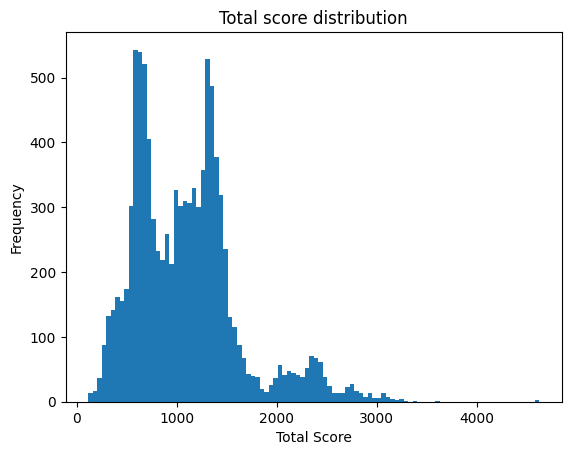

In [27]:
# Score distribution
plt.hist(baseline_scores, bins = 100)
plt.title("Total score distribution")
plt.xlabel("Total Score")
plt.ylabel("Frequency")
plt.show()

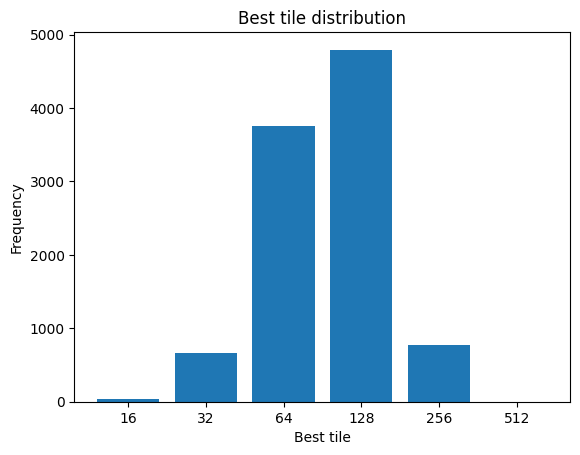

In [28]:
import math

# Best tile distribution
max_power = int(math.log(max(baseline_best_tiles), 2)) + 1
min_power = int(math.log(min(baseline_best_tiles), 2))
unique, counts = np.unique(baseline_best_tiles, return_counts=True)
plt.bar([str(2 ** i) for i in range(min_power, max_power)], counts)
plt.title("Best tile distribution")
plt.xlabel("Best tile")
plt.ylabel("Frequency")
plt.show()

In [ ]:
# TODO: refactor plots into functions

**Training**

In [44]:
from memory import ReplayMemory
from qnet import QNet
import torch

ModuleNotFoundError: No module named 'memory'

In [ ]:
# TODO: refactor constants
MEM_CAPACITY = 100000
NUM_STATES = 16
NUM_ACTIONS = 4
EPISODES = 200000
EPSILON_START = 0.9
EPSILON_END = 0.01
EPSILON_DECAY = 0.9999

# Initialize replay memory
replay_memory = ReplayMemory(MEM_CAPACITY)

# Initialize action-value function and target action-value function
qnet = QNet(NUM_STATES, NUM_ACTIONS)
qnet_target = QNet(NUM_STATES, NUM_ACTIONS)

# Iterate through the episodes
iterations = 0
epsilon = EPSILON_START
for episode in tqdm(range(EPISODES), total=EPISODES):
    # Initialize game for episode
    episode_game = Game()

    # Initialize the board
    # TODO: refactor board initialization in game class
    init_board = np.array([[0, 0, 0, 0], [0, 0, 0, 0], [0, 0, 0, 0], [0, 0, 0, 0]])
    board = episode_game.add_tile(init_board)
    board = episode_game.add_tile(board)

    # Step through the episode
    episode_done = False
    while not episode_done:
        # With probability epsilon select a random action, else choose from policy
        if random.uniform(0, 1) < epsilon:
            action = random.choice(list(Direction))
        else:
            with torch.no_grad():
                action = torch.argmax(qnet(board))
        
        # Update epsilon
        epsilon = epsilon * EPSILON_DECAY
        epsilon = max(epsilon, EPSILON_END)

        # Execute action and observe reward
        # TODO: extract reward from game class somehow
        result = episode_game.step(board, action)

        # ...